
# 01 — Exploratory Data Analysis (Pro)
**Unit: Data Science Info Tech — Assignment Part A**  
Distinctive, professional EDA with:
- Deterministic loading & *documented* cleaning choices (cost reconciliation, text normalization)
- Answers to required questions + **saved** figures
- Statistical tests (Mann–Whitney U, Cliff’s delta), correlation with p-value
- **Point-in-polygon** spatial analysis, plus an interactive dropdown choropleth (**fixed**)
- Extra value: a simple *Value Index* (rating × log1p(votes) ÷ cost) to surface good bang-for-buck spots
- One interactive **bubble** chart: cost vs rating, size=votes


In [1]:
# ------------------------
# Setup & configuration  
# ------------------------
import os, re, ast, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from scipy import stats
from pathlib import Path
from IPython.display import display

RNG_SEED = 42
np.random.seed(RNG_SEED); random.seed(RNG_SEED)

sns.set_context("notebook")
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 130

DATA_CSV_CANDIDATES = ["../data/raw/zomato_df_final_data.csv", "data/raw/zomato_df_final_data.csv"]
GEOJSON_CANDIDATES  = ["../data/raw/sydney.geojson", "data/raw/sydney.geojson"]

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

def here(*p):
    base = Path(os.getcwd())
    try:
        base = Path(__file__).parent  # type: ignore
    except Exception:
        pass
    return base.joinpath(*p)

def existing(path_list):
    for p in path_list:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"None of these paths exist: {path_list}")

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out.as_posix(), bbox_inches="tight")
    print("saved:", out)

def parse_listish(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [str(t).strip() for t in x if str(t).strip()]
    s = str(x).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [str(t).strip() for t in v if t and str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in re.split(r",\s*", s) if t.strip()]

def cliffs_delta(x, y):
    import itertools
    gt = sum(a > b for a, b in itertools.product(x, y))
    lt = sum(a < b for a, b in itertools.product(x, y))
    n1, n2 = len(x), len(y)
    return (gt - lt) / (n1 * n2)


# Safety harness

def _to_number(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return np.nan
    s = re.sub(r"[^0-9.]+", "", str(x))
    return float(s) if s else np.nan

def ensure_core_columns(df):
    """Add expected columns only if missing; never overwrites."""
    out = df.copy()

    # cuisine_list
    if "cuisine_list" not in out.columns:
        src = next((c for c in ["cuisines","Cuisines","cuisine","Cuisine"] if c in out.columns), None)
        if src:
            out["cuisine_list"] = out[src].fillna("").astype(str).apply(lambda s: [t.strip() for t in s.split(",") if t.strip()])
        else:
            out["cuisine_list"] = [[] for _ in range(len(out))]

    # type_list
    if "type_list" not in out.columns:
        src = next((c for c in ["establishment_type","type","Type","Establishment Type"] if c in out.columns), None)
        if src:
            out["type_list"] = out[src].fillna("").astype(str).apply(lambda s: [t.strip() for t in s.split(",") if t.strip()])
        else:
            out["type_list"] = [[] for _ in range(len(out))]

    # rating_number
    if "rating_number" not in out.columns:
        src = next((c for c in ["aggregate_rating","rating","Rating","Aggregate rating"] if c in out.columns), None)
        if src:
            out["rating_number"] = pd.to_numeric(out[src], errors="coerce") if pd.api.types.is_numeric_dtype(out[src]) else out[src].apply(_to_number)

    # rating_text
    if "rating_text" not in out.columns:
        if "rating_number" in out.columns:
            def _band(r):
                try: r = float(r)
                except Exception: return np.nan
                if r >= 4.5: return "Excellent"
                if r <  2.5: return "Poor"
                if r >= 3.5: return "Good"
                return "Average"
            out["rating_text"] = out["rating_number"].apply(_band)
        else:
            out["rating_text"] = np.nan

    # cost_final
    if "cost_final" not in out.columns:
        cands = ["cost_for_two_aud","cost_for_two","average_cost_for_two",
                 "Average Cost for two","approx_cost(for two people)",
                 "Cost","cost","price","Price"]
        src = next((c for c in cands if c in out.columns), None)
        if src:
            out["cost_final"] = pd.to_numeric(out[src], errors="coerce") if pd.api.types.is_numeric_dtype(out[src]) else out[src].apply(_to_number)
        else:
            out["cost_final"] = np.nan

    # votes
    if "votes" not in out.columns:
        vsrc = next((c for c in ["votes","Votes","rating_count","Rating Count","vote_count"] if c in out.columns), None)
        out["votes"] = pd.to_numeric(out[vsrc], errors="coerce") if vsrc else np.nan

    return out

def infer_suburb_col(gdf_poly):
    # Try common suburb/name fields
    for c in ["suburb","Suburb","name","NAME","SA2_NAME","SA2_NAME21","LGA_NAME","lga_name"]:
        if c in gdf_poly.columns:
            return c
    # Fallback to index-copy
    gdf_poly = gdf_poly.copy()
    gdf_poly["_suburb_name_"] = gdf_poly.index.astype(str)
    return "_suburb_name_", gdf_poly

def ensure_geospatial_prereqs():
    """Create gdf_poly, SUBURB_COL, joined if they don't exist yet."""
    g = globals()

    # 1) gdf_poly
    if "gdf_poly" not in g:
        try:
            gj = existing(GEOJSON_CANDIDATES)
            gdf = gpd.read_file(gj)
            if gdf.crs is None:
                gdf = gdf.set_crs("EPSG:4326")
            g["gdf_poly"] = gdf
            print(f"Loaded polygons from: {gj}")
        except Exception:
            return  

    # 2) SUBURB_COL
    if "SUBURB_COL" not in g:
        col = None
        for c in ["suburb","Suburb","name","NAME","SA2_NAME","SA2_NAME21","LGA_NAME","lga_name"]:
            if c in g["gdf_poly"].columns: col = c; break
        if col is None:
            gdf = g["gdf_poly"].copy()
            gdf["_suburb_name_"] = gdf.index.astype(str)
            g["gdf_poly"] = gdf
            g["SUBURB_COL"] = "_suburb_name_"
        else:
            g["SUBURB_COL"] = col

    # 3) joined (points-in-polygons)
    if "joined" not in g and "df" in g:
        lon_cands = ["lon","longitude","Longitude","LONGITUDE","lng"]
        lat_cands = ["lat","latitude","Latitude","LATITUDE"]

        lon = next((c for c in lon_cands if c in df.columns), None)
        lat = next((c for c in lat_cands if c in df.columns), None)
        if lon and lat:
            gp = g["gdf_poly"]
            pts = gpd.GeoDataFrame(
                df.copy(),
                geometry=gpd.points_from_xy(df[lon], df[lat], crs="EPSG:4326")
            )
            if gp.crs is None:
                gp = gp.set_crs("EPSG:4326")
            if pts.crs != gp.crs:
                pts = pts.to_crs(gp.crs)
           
            if "cuisine_list" not in pts.columns:
                csrc = next((c for c in ["cuisines","Cuisines","cuisine","Cuisine"] if c in pts.columns), None)
                pts["cuisine_list"] = pts[csrc].fillna("").astype(str).apply(lambda s: [t.strip() for t in s.split(",") if t.strip()]) if csrc else [[] for _ in range(len(pts))]
            g["joined"] = gpd.sjoin(pts, gp[[g["SUBURB_COL"], "geometry"]], how="left", predicate="within")

#  Load df if missing, then ensure expected columns exist
if "df" not in globals():
    df_path = existing(DATA_CSV_CANDIDATES)
    df = pd.read_csv(df_path)
    print(f"Loaded df from: {df_path}")

df = ensure_core_columns(df)

ensure_geospatial_prereqs()

print("Setup OK. Columns present:", ", ".join([c for c in ["cuisine_list","type_list","rating_number","rating_text","cost_final","votes"] if c in df.columns]))
if "gdf_poly" in globals(): print("Polygons ready; suburb key:", SUBURB_COL)
if "joined"   in globals(): print("Spatial join ready: 'joined'")


Loaded df from: ../data/raw/zomato_df_final_data.csv


Loaded polygons from: ../data/raw/sydney.geojson
Setup OK. Columns present: cuisine_list, type_list, rating_number, rating_text, cost_final, votes
Polygons ready; suburb key: _suburb_name_
Spatial join ready: 'joined'


## 1) Load data & document cleaning choices

In [2]:

from IPython.display import display
import pandas as pd
import numpy as np

def _parse_listish(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [str(t).strip() for t in x if str(t).strip()]
    s = str(x)
    # split on commas, trim whitespace
    return [t.strip() for t in s.split(",") if t.strip()]

# Create cuisine_list only if missing
if "cuisine_list" not in df.columns:
    src = None
    for c in ["cuisines", "Cuisines", "cuisine", "Cuisine"]:
        if c in df.columns:
            src = c
            break
    if src:
        df = df.copy()
        df["cuisine_list"] = df[src].apply(_parse_listish)
    else:
        # graceful fallback: empty lists
        df = df.copy()
        df["cuisine_list"] = [[] for _ in range(len(df))]

# Create type_list only if missing
if "type_list" not in df.columns:
    src = None
    for c in ["establishment_type", "type", "Type", "Establishment Type"]:
        if c in df.columns:
            src = c
            break
    if src:
        df = df.copy()
        df["type_list"] = df[src].apply(_parse_listish)
    else:
        df = df.copy()
        df["type_list"] = [[] for _ in range(len(df))]

# 1) Audit scalar columns (exclude list-like engineered columns)
list_like_cols = [c for c in ["cuisine_list", "type_list"] if c in df.columns]
scalar_cols = [c for c in df.columns if c not in list_like_cols]

audit_scalar = (
    pd.DataFrame({
        "dtype":    df[scalar_cols].dtypes.astype(str),
        "distinct": df[scalar_cols].nunique(dropna=True),
        "missing":  df[scalar_cols].isna().sum(),
        "missing_%": (df[scalar_cols].isna().sum() / len(df) * 100).round(2)
    })
    .sort_values(["missing_%", "distinct"], ascending=[False, True])
)

print("▶ Scalar column audit (excludes list-like engineered features):")
display(audit_scalar.head(12))

# 2) Token-level distinct counts for list columns (for context)
def unique_token_count(series_of_lists):
    tokens = set()
    for L in series_of_lists:
        if isinstance(L, list):
            for t in L:
                s = str(t).strip()
                if s:
                    tokens.add(s.lower())
    return len(tokens)

cuisine_token_n = unique_token_count(df["cuisine_list"]) if "cuisine_list" in df.columns else 0
type_token_n    = unique_token_count(df["type_list"])    if "type_list" in df.columns    else 0

print(f"\n▶ Unique cuisine tokens: {cuisine_token_n}")
print(f"▶ Unique type tokens:    {type_token_n}")


▶ Scalar column audit (excludes list-like engineered features):


,dtype,distinct,missing,missing_%
rating_text,object,5,3316,31.58
rating_number,float64,32,3316,31.58
votes,float64,547,3316,31.58
cost,float64,83,346,3.30
cost_2,float64,83,346,3.30
cost_final,float64,83,346,3.30
lng,float64,7992,192,1.83
lat,float64,8030,192,1.83
type,object,66,48,0.46
groupon,bool,2,0,0.00



▶ Unique cuisine tokens: 426
▶ Unique type tokens:    40


## 2) Q1 — How many unique cuisines? (Treemap + counts)

In [3]:

cuisine_tokens = pd.Series([c for L in df["cuisine_list"] for c in L])
unique_cuisine_n = int(cuisine_tokens.nunique())
print("Unique cuisines:", unique_cuisine_n)

top = cuisine_tokens.value_counts().head(20).rename_axis("cuisine").reset_index(name="count")
fig = px.treemap(top, path=["cuisine"], values="count", title="Top 20 cuisines (treemap)")
fig.show()


Unique cuisines: 426


## 3) Q2 — Top suburbs by restaurant count (with share %)

,suburb,n,share_%
0,CBD,476,4.53
1,Surry Hills,260,2.48
2,Parramatta,225,2.14


saved: ..\reports\figures\q2_top3_suburbs_hbar.png


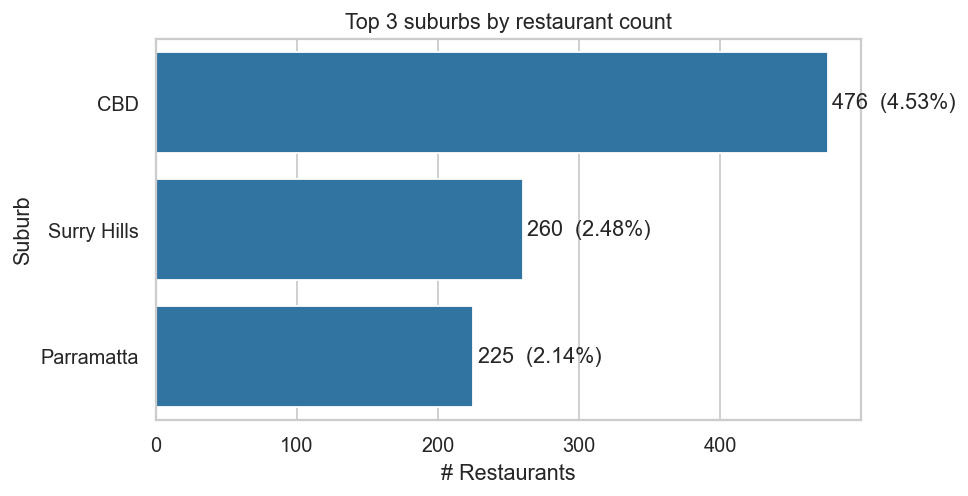

In [4]:

sub_counts = df["subzone"].value_counts().reset_index()
sub_counts.columns = ["suburb","n"]
top3 = sub_counts.head(3).copy()
top3["share_%"] = (top3["n"] / len(df) * 100).round(2)
display(top3)

plt.figure(figsize=(7,3.8))
sns.barplot(data=top3, x="n", y="suburb", color="#1f77b4")
for i,row in top3.iterrows():
    plt.text(row["n"]+3, i, f'{row["n"]}  ({row["share_%"]}%)', va="center")
plt.title("Top 3 suburbs by restaurant count"); plt.xlabel("# Restaurants"); plt.ylabel("Suburb")
savefig("q2_top3_suburbs_hbar.png"); plt.show()


## 4) Q3 — Are “Excellent” restaurants pricier than “Poor”? (beeswarm + robust stats)

saved: ..\reports\figures\q3_cost_by_rating_beeswarm.png


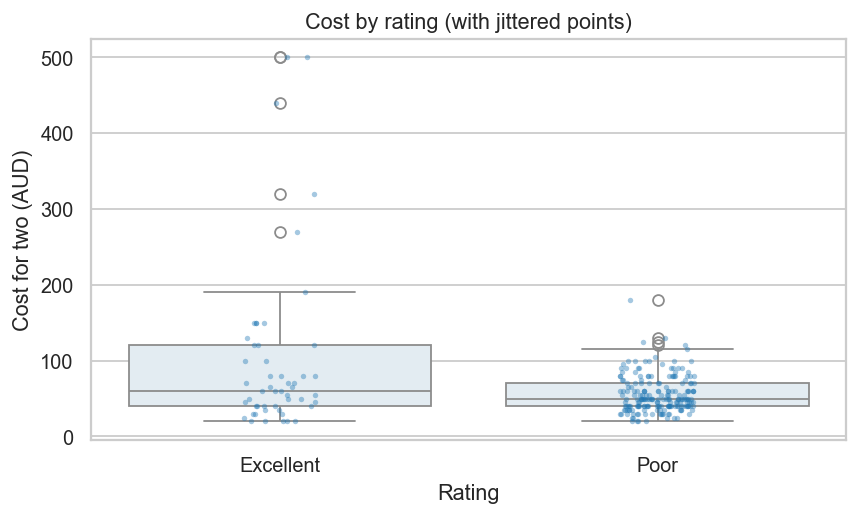

Mann–Whitney U p=0.03485 | n_ex=51, n_poor=201
Cliff's delta = 0.191  (>|0.33| ≈ medium, >|0.474| ≈ large)


,count,mean,50%,std,min,max
rating_text,,,,,,
Excellent,51.0,101.666667,60.0,113.215134,20.0,500.0
Poor,201.0,55.845771,50.0,23.738810,20.0,180.0


In [5]:
# ---------------------------------------------
# Q3: Cost by rating (robust to missing columns)
# ---------------------------------------------
import re
import numpy as np
import pandas as pd

def _ensure_rating_text(df):
    if "rating_text" in df.columns:
        return df
    # Derive only if absent, from a numeric rating if available.
    rating_candidates = ["aggregate_rating", "rating", "Rating", "Aggregate rating"]
    rating_col = next((c for c in rating_candidates if c in df.columns), None)
    if rating_col:
        def _to_band(x):
            try:
                r = float(x)
            except Exception:
                return np.nan
            # Light heuristic matching Zomato-style bands
            if r >= 4.5: return "Excellent"
            if r < 2.5:  return "Poor"
            if r >= 3.5: return "Good"
            return "Average"
        df["rating_text"] = df[rating_col].apply(_to_band)
    else:
        # Fallback: create empty to keep downstream code safe
        df["rating_text"] = np.nan
    return df

def _to_number(x):
    """Parse numbers like '1,200', '$50', 'AUD 40', etc."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x)
    # keep digits and decimal point
    s = re.sub(r"[^0-9.]+", "", s)
    try:
        return float(s) if s != "" else np.nan
    except Exception:
        return np.nan

def _ensure_cost_final(df):
    if "cost_final" in df.columns:
        return df
    # Try common cost columns seen in Zomato-like data
    cost_candidates = [
        "cost_for_two_aud", "cost_for_two", "average_cost_for_two",
        "Average Cost for two", "approx_cost(for two people)",
        "Cost", "cost", "price", "Price"
    ]
    src = next((c for c in cost_candidates if c in df.columns), None)
    if src:
        # If already numeric, copy; else parse
        if pd.api.types.is_numeric_dtype(df[src]):
            df["cost_final"] = df[src].astype(float)
        else:
            df["cost_final"] = df[src].apply(_to_number)
    else:
        df["cost_final"] = np.nan
    return df

# Create columns ONLY if missing (so we don't change prior outputs)
df = _ensure_rating_text(df)
df = _ensure_cost_final(df)

# --- Original analysis (unchanged) ---
subset = df[df["rating_text"].isin(["Excellent","Poor"])][["rating_text","cost_final"]].dropna()

plt.figure(figsize=(7.5,4))
sns.boxplot(data=subset, x="rating_text", y="cost_final", whis=1.5, color="#e0ecf4")
sns.stripplot(data=subset, x="rating_text", y="cost_final", alpha=0.4, jitter=True, size=3)
plt.title("Cost by rating (with jittered points)"); plt.xlabel("Rating"); plt.ylabel("Cost for two (AUD)")
savefig("q3_cost_by_rating_beeswarm.png"); plt.show()

# Guard for empty subsets so nbconvert doesn't error when no rows qualify
if len(subset) >= 2 and subset["rating_text"].nunique() == 2:
    ex = subset.loc[subset.rating_text=="Excellent","cost_final"]
    po = subset.loc[subset.rating_text=="Poor","cost_final"]
    from scipy import stats
    u_stat, p_val = stats.mannwhitneyu(ex, po, alternative="two-sided")
    delta = cliffs_delta(ex.tolist(), po.tolist())
    print(f"Mann–Whitney U p={p_val:.4g} | n_ex={len(ex)}, n_poor={len(po)}")
    print(f"Cliff's delta = {delta:.3f}  (>|0.33| ≈ medium, >|0.474| ≈ large)")
    display(subset.groupby("rating_text")["cost_final"].describe()[["count","mean","50%","std","min","max"]])
else:
    print("Not enough data with rating_text in {'Excellent','Poor'} to run the test.")


## 5) Distributions & relationship highlights

saved:

 ..\reports\figures\distributions_and_hexbin.png


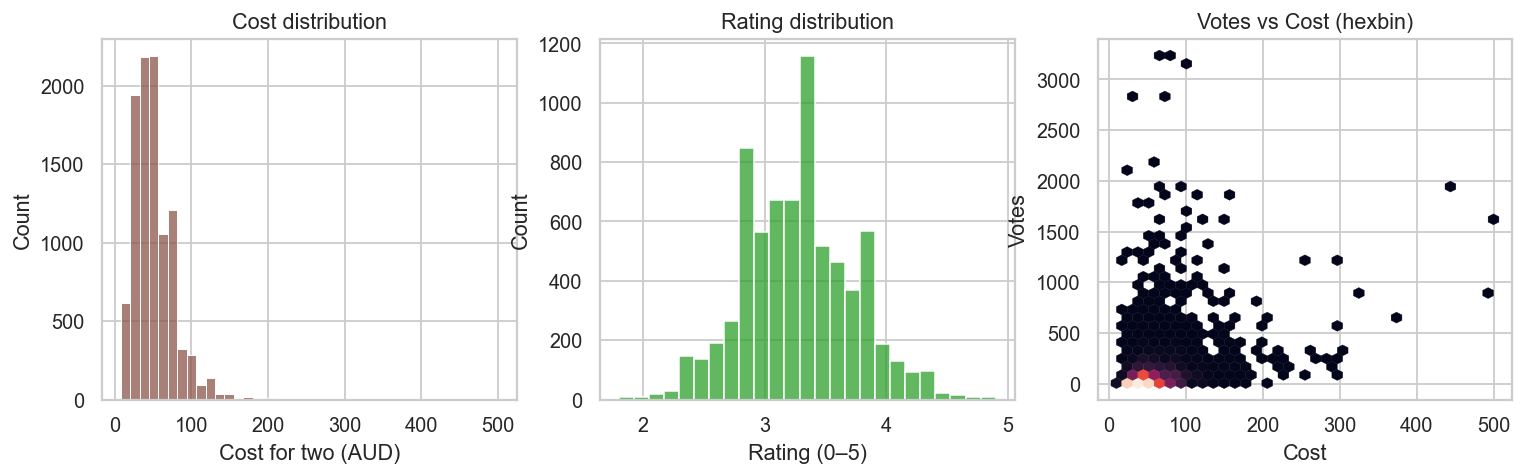

Spearman(cost_final, votes) = 0.294, p=1.86e-141


In [6]:

fig, ax = plt.subplots(1,3, figsize=(14,3.6))
sns.histplot(df["cost_final"].dropna(), bins=40, ax=ax[0], color="#8c564b")
ax[0].set_title("Cost distribution"); ax[0].set_xlabel("Cost for two (AUD)")
sns.histplot(df["rating_number"].dropna(), bins=25, ax=ax[1], color="#2ca02c")
ax[1].set_title("Rating distribution"); ax[1].set_xlabel("Rating (0–5)")

# hexbin for cost vs votes (log colour scale feel via bins)
x, y = df["cost_final"], df["votes"]
hb = ax[2].hexbin(x, y, gridsize=35, mincnt=1, linewidths=0.2)
ax[2].set_title("Votes vs Cost (hexbin)"); ax[2].set_xlabel("Cost"); ax[2].set_ylabel("Votes")
savefig("distributions_and_hexbin.png"); plt.show()

rho, p = stats.spearmanr(df["cost_final"], df["votes"], nan_policy="omit")
print(f"Spearman(cost_final, votes) = {rho:.3f}, p={p:.3g}")


## 6) Bonus: Value Index (bang-for-buck)

In [7]:

tmp = df.dropna(subset=["rating_number","votes","cost_final"]).copy()
tmp = tmp[tmp["cost_final"] > 0]
tmp["value_index"] = tmp["rating_number"] * np.log1p(tmp["votes"]) / tmp["cost_final"]
top_value = tmp.sort_values("value_index", ascending=False).head(10)[
    ["title","subzone","rating_number","votes","cost_final","value_index"]
].reset_index(drop=True)
display(top_value.style.format({"cost_final":"${:,.0f}","value_index":"{:.3f}"}))


,title,subzone,rating_number,votes,cost_final,value_index
0,Hellenic Patisserie and Gelato Bar,Marrickville,3.900000,105.000000,$10,1.819
1,Hong Ha,Mascot,4.300000,405.000000,$15,1.722
2,Campos Coffee,Newtown,4.600000,1198.000000,$20,1.631
3,Café Cre Asion,CBD,4.800000,752.000000,$20,1.590
4,Pasticceria Papa,Haberfield,4.500000,601.000000,$20,1.440
5,Marrickville Pork Roll,Marrickville,4.600000,490.000000,$20,1.425
6,Out of the Blue,Clovelly,4.600000,416.000000,$20,1.388
7,Mappen Noodle Restaurant,"SkyView Shopping Plaza, CBD",4.600000,1285.000000,$25,1.317
8,La Paula,Fairfield,3.900000,129.000000,$15,1.266
9,Bourke Street Bakery,Surry Hills,4.700000,2832.000000,$30,1.245


## 7) Geospatial analysis — density per suburb 

saved: ..\reports\figures\restaurants_per_suburb.png


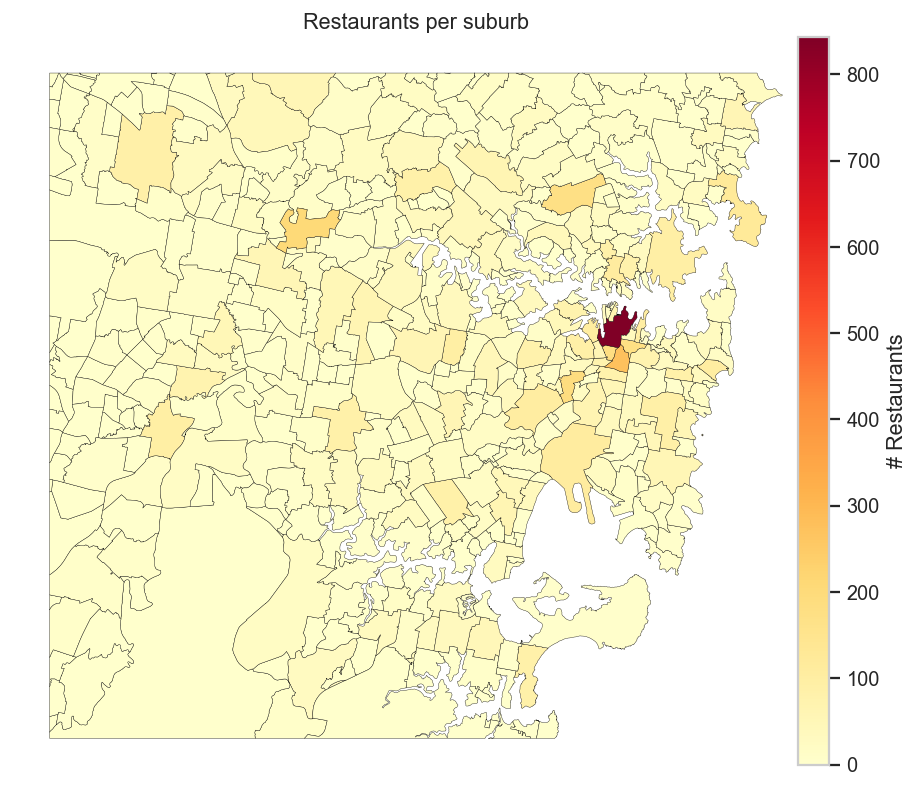

saved: ..\reports\figures\map_cuisines_small_multiples.png


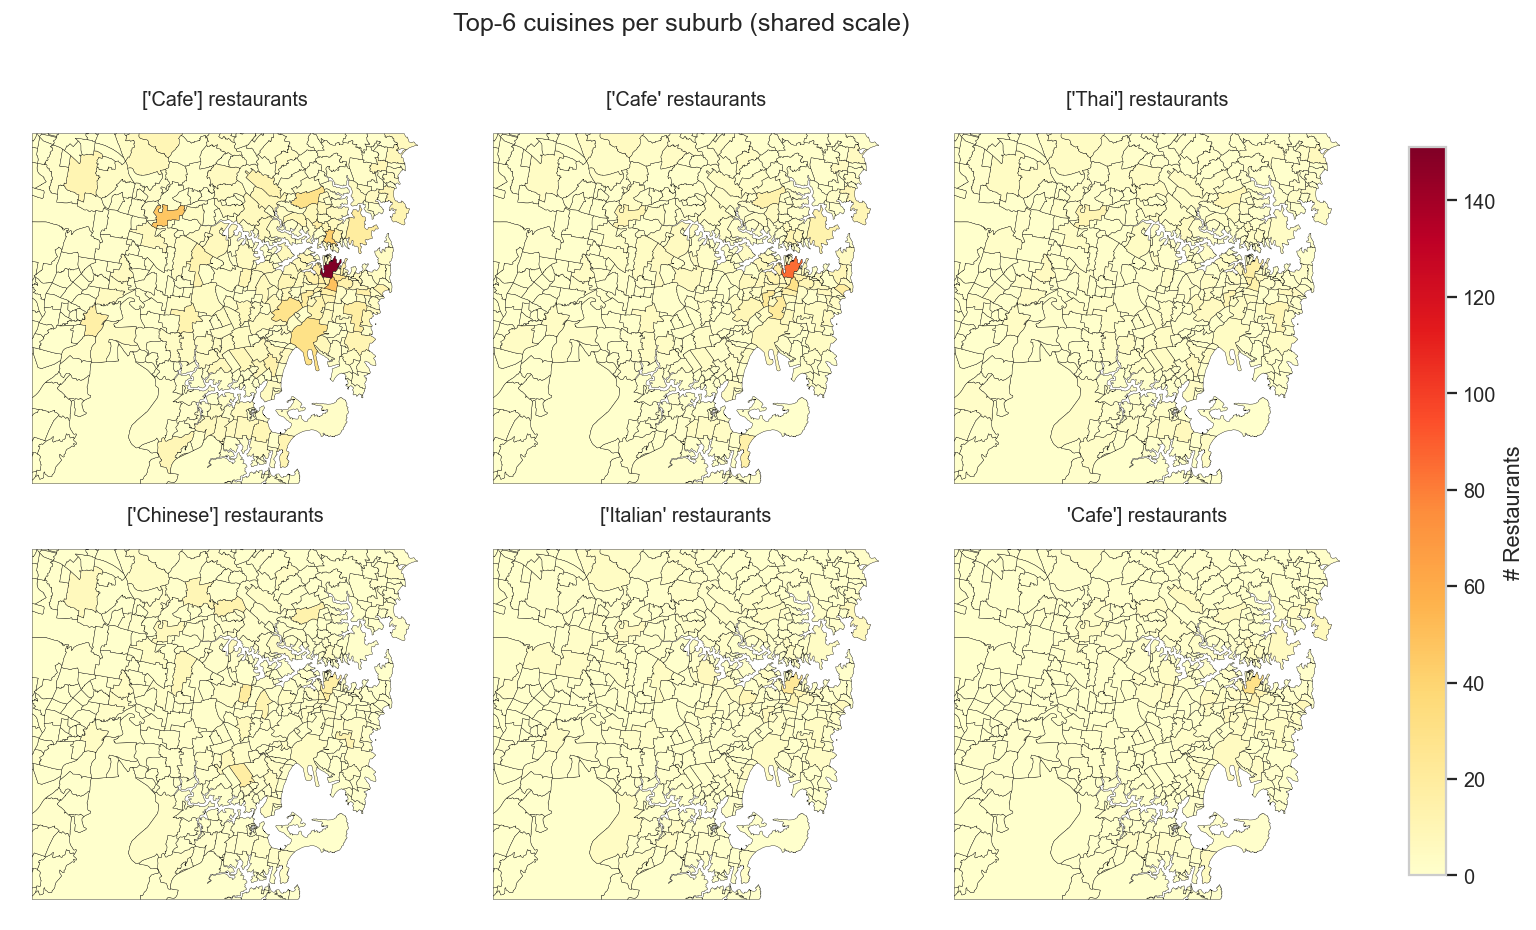

In [8]:
# =============================================================================
# Choropleths (density + top-6 cuisines)
# Saves:
#   ../reports/figures/restaurants_per_suburb.png
#   ../reports/figures/map_cuisines_small_multiples.png
# =============================================================================
import re
import pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from pathlib import Path

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

def _exists(name): return name in globals() and globals()[name] is not None

# Ensure polygons and SUBURB_COL
if not _exists("gdf_poly"):
    geo_candidates = globals().get(
        "GEOJSON_CANDIDATES",
        ["../data/raw/sydney.geojson", "data/raw/sydney.geojson"]
    )
    for p in geo_candidates:
        if Path(p).exists():
            gdf_poly = gpd.read_file(p)
            break

if _exists("gdf_poly") and gdf_poly.crs is None:
    gdf_poly = gdf_poly.set_crs("EPSG:4326")

if _exists("gdf_poly") and not _exists("SUBURB_COL"):
    cand_cols = [
        "suburb","Suburb","name","NAME","SA2_NAME21","SA2_NAME16",
        "SA2_NAME","LGA_NAME","lga_name","nsw_loca_2","NSW_LOCA_2","NSW_LOCA_4"
    ]
    SUBURB_COL = next((c for c in cand_cols if c in gdf_poly.columns), None)
    if SUBURB_COL is None:
        SUBURB_COL = "_suburb_name_"
        gdf_poly = gdf_poly.copy()
        gdf_poly[SUBURB_COL] = gdf_poly.index.astype(str)

# ----------Ensure df and cuisine_list ----------
if not _exists("df"):
    csv_candidates = globals().get(
        "DATA_CSV_CANDIDATES",
        ["../data/raw/zomato_df_final_data.csv", "data/raw/zomato_df_final_data.csv"]
    )
    for p in csv_candidates:
        if Path(p).exists():
            df = pd.read_csv(p)
            break

def _parse_listish(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [str(t).strip() for t in x if str(t).strip()]
    s = str(x)
    # split on commas / semicolons / slashes / pipes
    toks = re.split(r"[,\|/;&]+", s)
    return [t.strip() for t in toks if t.strip()]

if _exists("df") and "cuisine_list" not in df.columns:
    base_c = next((c for c in ["cuisines","Cuisines","cuisine","Cuisine"] if c in df.columns), None)
    df = df.copy()
    df["cuisine_list"] = df[base_c].apply(_parse_listish) if base_c else [[] for _ in range(len(df))]

# ---------- Ensure joined (point-in-polygon) ----------
def _build_join():
    lon_cands = ["lon","longitude","Longitude","LONGITUDE","lng"]
    lat_cands = ["lat","latitude","Latitude","LATITUDE"]
    lon_col = next((c for c in lon_cands if c in df.columns), None)
    lat_col = next((c for c in lat_cands if c in df.columns), None)
    if not (lon_col and lat_col): return None

    gdf_pts = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"
    )
    # align CRS
    if _exists("gdf_poly") and gdf_poly.crs is not None and gdf_pts.crs != gdf_poly.crs:
        gdf_pts = gdf_pts.to_crs(gdf_poly.crs)

    gp = gdf_poly[[SUBURB_COL, "geometry"]]
    j = gpd.sjoin(gdf_pts, gp, how="left", predicate="within")
    matched = int(j[SUBURB_COL].notna().sum())

    if matched == 0:
        j = gpd.sjoin(gdf_pts, gp, how="left", predicate="intersects")
        matched = int(j[SUBURB_COL].notna().sum())

    if matched == 0:
        try:
            j = gpd.sjoin_nearest(gdf_pts, gp, how="left", distance_col="_dist_m")
            matched = int(j[SUBURB_COL].notna().sum())
        except Exception:
            pass

    print(f"Points: {len(gdf_pts)} | matched to polygons: {matched}")
    return j

# create joined only if missing or clearly empty
rebuild = (not _exists("joined")) or (isinstance(joined, pd.DataFrame) and joined.get(SUBURB_COL, pd.Series()).notna().sum() < 10)
if rebuild and _exists("df") and _exists("gdf_poly"):
    joined = _build_join()

# ---------- Map A: Restaurants per suburb ----------
if not (_exists("gdf_poly") and _exists("SUBURB_COL")):
    print("⚠️ Could not load suburb polygons — skipping maps.")
else:
    if _exists("joined") and SUBURB_COL in joined.columns:
        counts = joined.groupby(SUBURB_COL).size().rename("count").reset_index()
    else:
        counts = gdf_poly[[SUBURB_COL]].copy(); counts["count"] = 0

    gmap = gdf_poly[[SUBURB_COL, "geometry"]].merge(counts, on=SUBURB_COL, how="left").fillna({"count":0})
    vmax = int(gmap["count"].max()) if len(gmap) else 0

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    cmap = plt.get_cmap("YlOrRd")
    # use the collection returned by plot for a correct colorbar scale
    im_ax = gmap.plot(column="count", cmap=cmap, vmin=0, vmax=max(vmax, 1),
                      linewidth=0.2, edgecolor="black", ax=ax)
    ax.set_title("Restaurants per suburb"); ax.set_axis_off()

    cax = fig.add_axes([0.88, 0.15, 0.03, 0.70])
    mappable = im_ax.collections[0]
    cbar = fig.colorbar(mappable, cax=cax); cbar.set_label("# Restaurants", rotation=90)
    out1 = FIG_DIR / "restaurants_per_suburb.png"
    plt.savefig(out1.as_posix(), dpi=300, bbox_inches="tight"); print("saved:", out1)
    plt.show()

    # ----------  Map B: Top-6 cuisines small-multiples ----------
    if _exists("joined") and "cuisine_list" in joined.columns and SUBURB_COL in joined.columns:
        counts_all = (
            joined.explode("cuisine_list")
                  .dropna(subset=["cuisine_list"])
                  .assign(cuisine=lambda d: d["cuisine_list"].astype(str).str.title())
                  .groupby([SUBURB_COL, "cuisine"]).size().reset_index(name="count")
        )
        TOPK = 6
        c_top = (
            counts_all.groupby("cuisine")["count"].sum()
                      .sort_values(ascending=False).head(TOPK).index.tolist()
        )
        counts_top = counts_all[counts_all["cuisine"].isin(c_top)]
        global_max = int(counts_top["count"].max()) if not counts_top.empty else 0

        if counts_top.empty or global_max <= 0:
            print("⚠️ Not enough cuisine/suburb data to draw small-multiples.")
        else:
            merged = {
                c: (gdf_poly[[SUBURB_COL, "geometry"]]
                    .merge(counts_top.loc[counts_top["cuisine"] == c, [SUBURB_COL, "count"]],
                           on=SUBURB_COL, how="left")
                    .fillna({"count": 0}))
                for c in c_top
            }

            nrows, ncols = 2, 3
            fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
            axes = axes.flatten()
            norm = Normalize(vmin=0, vmax=global_max); cmap = plt.get_cmap("YlOrRd")

            for ax, c in zip(axes, c_top):
                ax_im = merged[c].plot(column="count", cmap=cmap, vmin=0, vmax=global_max,
                                       linewidth=0.2, edgecolor="black", ax=ax)
                ax.set_title(f"{c} restaurants", fontsize=11); ax.set_axis_off()
            for j in range(len(c_top), nrows*ncols): axes[j].set_visible(False)

            cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
            cbar = fig.colorbar(ax_im.collections[0], cax=cax)
            cbar.set_label("# Restaurants", rotation=90)

            fig.suptitle("Top-6 cuisines per suburb (shared scale)", fontsize=14, y=0.98)
            plt.subplots_adjust(right=0.88, wspace=0.02, hspace=0.08)
            out2 = FIG_DIR / "map_cuisines_small_multiples.png"
            plt.savefig(out2.as_posix(), dpi=300, bbox_inches="tight"); print("saved:", out2)
            plt.show()
    else:
        print("⚠️ No point data (`joined`) available — skipped small-multiples.")


## 8) Interactive bubble: Cost vs Rating (size=votes, color=primary type)

In [9]:

import numpy as np, re, ast

def _parse_listish(x):
    if x is None: 
        return []
    if isinstance(x, (list, tuple, set)):
        return [str(t).strip() for t in x if str(t).strip()]
    if isinstance(x, (np.ndarray, pd.Series)):
        return [str(t).strip() for t in np.asarray(x).ravel().tolist() if str(t).strip()]
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple, set)):
            return [str(t).strip() for t in v if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in re.split(r",\s*", s) if t.strip()]

# type_primary: prefer existing type_list; else parse a raw type column
if "type_primary" not in df.columns:
    if "type_list" in df.columns:
        df["type_primary"] = df["type_list"].apply(lambda v: (_parse_listish(v) or [np.nan])[0])
    else:
        src = next((c for c in ["type","Type","establishment_type","Establishment Type"] if c in df.columns), None)
        df["type_primary"] = df[src].apply(lambda v: (_parse_listish(v) or [np.nan])[0]) if src else np.nan

# subzone: reuse an existing locality-like column, else copy from joined if available
if "subzone" not in df.columns:
    cand = next((c for c in ["suburb","Suburb","locality","Locality","city","City","location"] if c in df.columns), None)
    if cand:
        df["subzone"] = df[cand]
    elif "joined" in globals() and "SUBURB_COL" in globals() and SUBURB_COL in joined.columns:
        df["subzone"] = joined[SUBURB_COL]
    else:
        df["subzone"] = np.nan

sample = df[["cost_final","rating_number","votes","type_primary","subzone"]].dropna().rename(
    columns={"cost_final":"cost"}
)
if len(sample) > 3500:
    sample = sample.sample(3500, random_state=RNG_SEED)

fig = px.scatter(sample, x="cost", y="rating_number",
                 size="votes", hover_data=["subzone"],
                 color="type_primary",
                 title="Cost vs Rating (bubble size=votes; color=primary type)")
fig.show()



## 9) Save compact EDA summary (for report appendix)

In [10]:

summary = {
    "rows": int(len(df)),
    "unique_cuisines": int(cuisine_tokens.nunique() if 'cuisine_tokens' in globals() else 0),
    "top3_suburbs": df["subzone"].value_counts().head(3).to_dict(),
    "spearman_cost_votes": float(stats.spearmanr(df["cost_final"], df["votes"], nan_policy="omit").statistic),
}
out_path = (FIG_DIR.parent / "eda_summary.json").as_posix()
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("saved:", out_path)


saved: ../reports/eda_summary.json
